# Finding the Linear Stage Position Corresponding to a 0 Delay for the STED Laser
We are running an experiment to investigate the effect of Stimulated Emission Delpletion (STED) on single photon emission from a colour centre defect in hexagonal Boron Nitride (hBN). A laser emits a pulse containing a range of wavelengths which are split up and filtered to produce a 532 nm excitation pulse and a red pulse of energy 0.2eV less than the Zero Phonon Line emission from the defect, which causes the STED. A linear stage with a mirror is included in the setup to introduce a delay between the STED pulse and the excitation. We want to know the position of the stage that corresponds to a 0 delay between the two pulses, so that we know the starting point from which we can then introduce a delay.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit

In [2]:
def Gaussian(x, a, b, c):
    """Returns a Gaussian function which can be used to curve fit to the data. a represents the amplitude, b the
    stage position, and c the ilnewidth (standard deviation)"""
    y = a*np.exp(-0.5*((x-b)/c)**2)
    return y

In [3]:
def mod_function(x, a, b):
    """Returns a modulus function that can be used for curve fiting"""
    y = a* abs(x-b)
    return y

# Need to make sure the code is in the same folder as the data
Might try and fix this so I don't have to do this

In [4]:
#Define the path of the folder containing the data
Root_folder = r'C:\Users\seanj\OneDrive - University of Exeter\Time Tagger Data'

In [5]:
#Determining the maximum point of the data set. This is where the Gaussian pulse will be. I can then only take data 
#points around this value to shorten the array and make the code much more efficient.
stage_0_position = glob.glob(Root_folder + '\*Green*0um.txt') #Here Green and 0um are used to select the initial measurement from the green laser. Would need to change this if using a different filename.
data = np.loadtxt(stage_0_position[0])
time_bin = []
amplitude = []
for i in range(len(data)):
    time_bin.append(data[i][0])
    amplitude.append(data[i][1])
index = []
for i in range(len(amplitude)):
    if amplitude[i] == max(amplitude):
        index = i
    else:
        pass
print(index)

4910


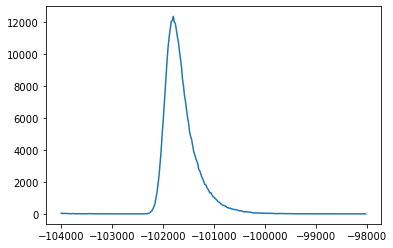

In [17]:
plt.figure()
plt.plot(time_bin[4800:5100], amplitude[4800:5100])
#Only interested in the time bins containing the pulse

In [18]:
def curve_fit_green(position, show_graph = False):
    """Imports the text file for the green pulse at the specified data position. Reduces the array to only include 
    the pulse, and then further up to only the peak. Then fits a Gaussian to the 'half Gaussian' pulse remianing. 
    Don't inlcude the other half of the pulse because experimental errors mean that what is measured is not a true 
    Gaussian form. Calculates the Full Width Half Maximum and fwhm point on the left hand side of the Gaussian pulse is 
    used as the refernece point for the time bin of the pulse. Optional parameter plots the graph of the fit and 
    the fwhm point. Here Position is in units of um."""
    
    #imoprt the data
    filename = glob.glob(Root_folder + '\*Green*'+str(position)+'*.txt')
    data = np.loadtxt(filename[0])

    time_bin = []
    amplitude = []
    #take the text file and put it into numpy arrays
    for i in range(len(data)):
        time_bin.append(data[i][0])
        amplitude.append(data[i][1])
    #Splice the array to only keep the region of the array where the pulse is. This will reduce processing times
    time_bin_reduced = time_bin[4850:5100]
    amplitude_reduced = amplitude[4850:5100]
    #Find the peak of the pulse
    index = []
    for i in range(len(amplitude_reduced)):
        if amplitude_reduced[i] == max(amplitude_reduced):
            index = i
        else:
            pass
    #Splice the array again to only keep the region before the peak. This array can then be used to fit to a Gaussian curve
    time_bin_reduced2 = time_bin_reduced[0:index]
    amplitude_reduced2 = amplitude_reduced[0:index]
    params = curve_fit(Gaussian, time_bin_reduced2, amplitude_reduced2, p0 = (12000, -100000, 1000))[0] #set initial guess because otherwise can give errors
    #Calculate the Full Width Half Maximum of the Gaussian pulse
    fwhm = np.sqrt(2*np.log(2))*abs(params[2]) #Actual fwhm is double this but I am only interested in the half before the maximum point
    fwhm_point = params[1] - fwhm
    
    if show_graph == True:
        plt.figure(figsize = (20, 12))
        plt.scatter(time_bin_reduced2, amplitude_reduced2)
        plt.plot(time_bin_reduced2, Gaussian(time_bin_reduced2, params[0], params[1], params[2]))
        plt.plot(time_bin_reduced2, np.ones(len(time_bin_reduced2)) * max(amplitude_reduced2)/2,  '--', c='r')
        plt.plot(np.ones(1000)*params[1]-fwhm, np.linspace(0, max(amplitude_reduced2), 1000),  '--', c='r')
        plt.xlabel('Time Bin', fontsize = 30)
        plt.ylabel('Counts Per Bin', fontsize = 30)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.title('Green Laser - Stage Position:' + str(position) + '$\mu$m', fontsize = 36)
    
    return params, fwhm_point

(array([  12283.50914424, -101832.46991663,     143.9137954 ]),
 -102001.91546171902)

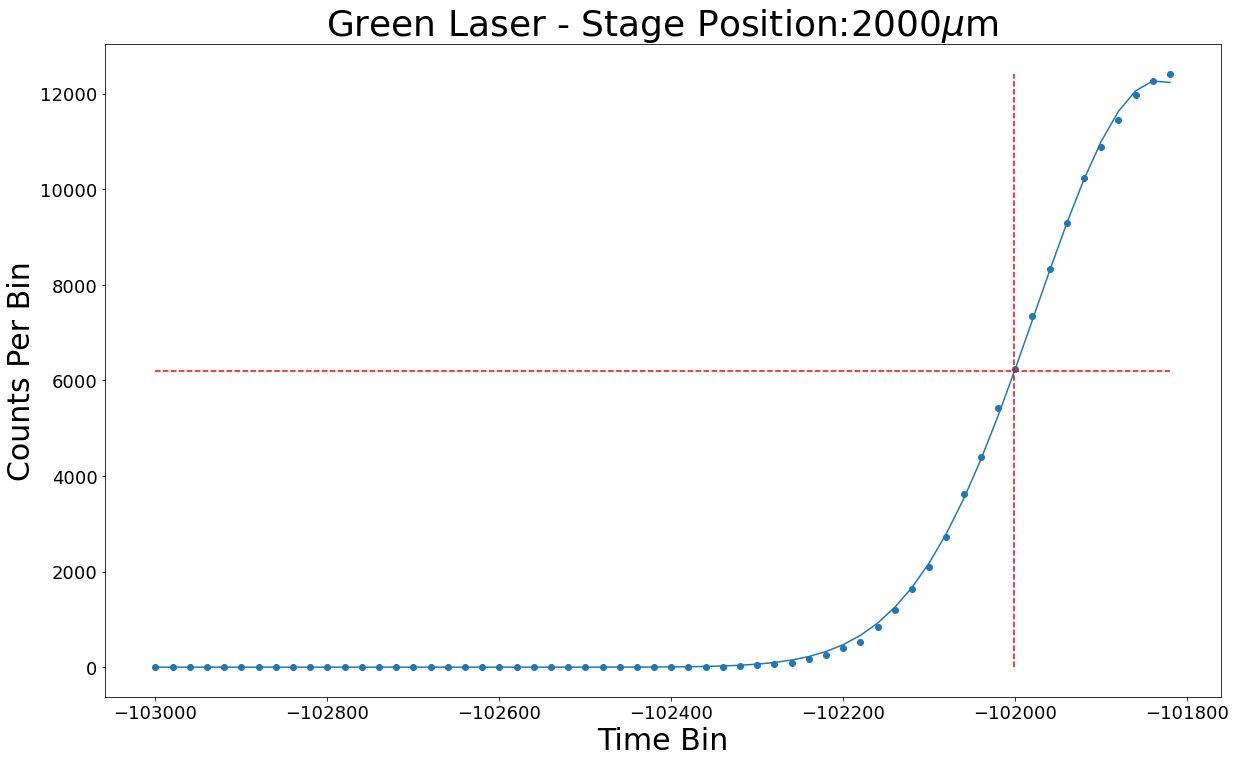

In [19]:
curve_fit_green(2000, show_graph = True)

In [14]:
def curve_fit_red(repeat, show_graph = False):
    """Repeats the same process as for the green function except for the red laser pulse. The repeat corresponds to a
    string of the label on the data set which follows the convention of M2 for the second repeat, M3 for the third, and
    nothing for the first repeat. The different repeats are after adjustments to the stage to try and give the 
    optimal 0 time delay position which means we have a larger range through which we can change the delay. Therefore
    the repeats shouldn't be the same."""
    
    filename = glob.glob(r'C:\Users\seanj\OneDrive - University of Exeter\Time Tagger Data\*Red*'+repeat+'*.txt')
    filename = glob.glob(Root_folder + '\*Red*'+repeat+'*.txt')
    data = np.loadtxt(filename[0])

    #Follows the same process as the curve_fit_green function
    
    time_bin = []
    amplitude = []
    for i in range(len(data)):
        time_bin.append(data[i][0])
        amplitude.append(data[i][1])
    time_bin_reduced = time_bin[4850:5100]
    amplitude_reduced = amplitude[4850:5100]
    index = []
    for i in range(len(amplitude_reduced)):
        if amplitude_reduced[i] == max(amplitude_reduced):
            index = i
        else:
            pass
    time_bin_reduced2 = time_bin_reduced[0:index]
    amplitude_reduced2 = amplitude_reduced[0:index]
    params = curve_fit(Gaussian, time_bin_reduced2, amplitude_reduced2, p0 = (12000, -100000, 1000))[0]
    fwhm = np.sqrt(2*np.log(2))*params[2] #Actual fwhm is double this but I am only interested in the half before the maximum point
    fwhm_point = params[1] - fwhm
    
    if show_graph == True:
        plt.figure(figsize = (20, 12))
        plt.scatter(time_bin_reduced2, amplitude_reduced2)
        plt.plot(time_bin_reduced2, Gaussian(time_bin_reduced2, params[0], params[1], params[2]))
        plt.plot(time_bin_reduced2, np.ones(len(time_bin_reduced2)) * max(amplitude_reduced2)/2,  '--', c='r')
        plt.plot(np.ones(1000)*params[1]-fwhm, np.linspace(0, max(amplitude_reduced2), 1000),  '--', c='r')
        plt.xlabel('Time Bin', fontsize = 30)
        plt.ylabel('Counts Per Bin', fontsize = 30)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        
    
    return params, fwhm_point

In [78]:
#Creates an array of the fwhm points for all the green positions
fwhm_points = []
for i in range(101):
    fwhm_points.append(curve_fit_green(i*1000)[1])

In [91]:
#Calculates the time difference between the red and green pulse at each stage position. Then fits this array to a 
#modulus function to find the 0 point, which corresponds to the stage position which gives 0 time delay.
delta_t1 = abs(fwhm_points - curve_fit_red('M1')[1])
delta_t1_params = curve_fit(mod_function, np.linspace(0, 100, 101), delta_t1, p0 = (8, 60))[0]
delta_t2 = abs(fwhm_points - curve_fit_red('M2')[1])
delta_t2_params = curve_fit(mod_function, np.linspace(0, 100, 101), delta_t2, p0 = (8, 85))[0]
delta_t3 = abs(fwhm_points - curve_fit_red('M3')[1])
delta_t3_params = curve_fit(mod_function, np.linspace(0, 100, 101), delta_t3, p0 = (8, 35))[0]

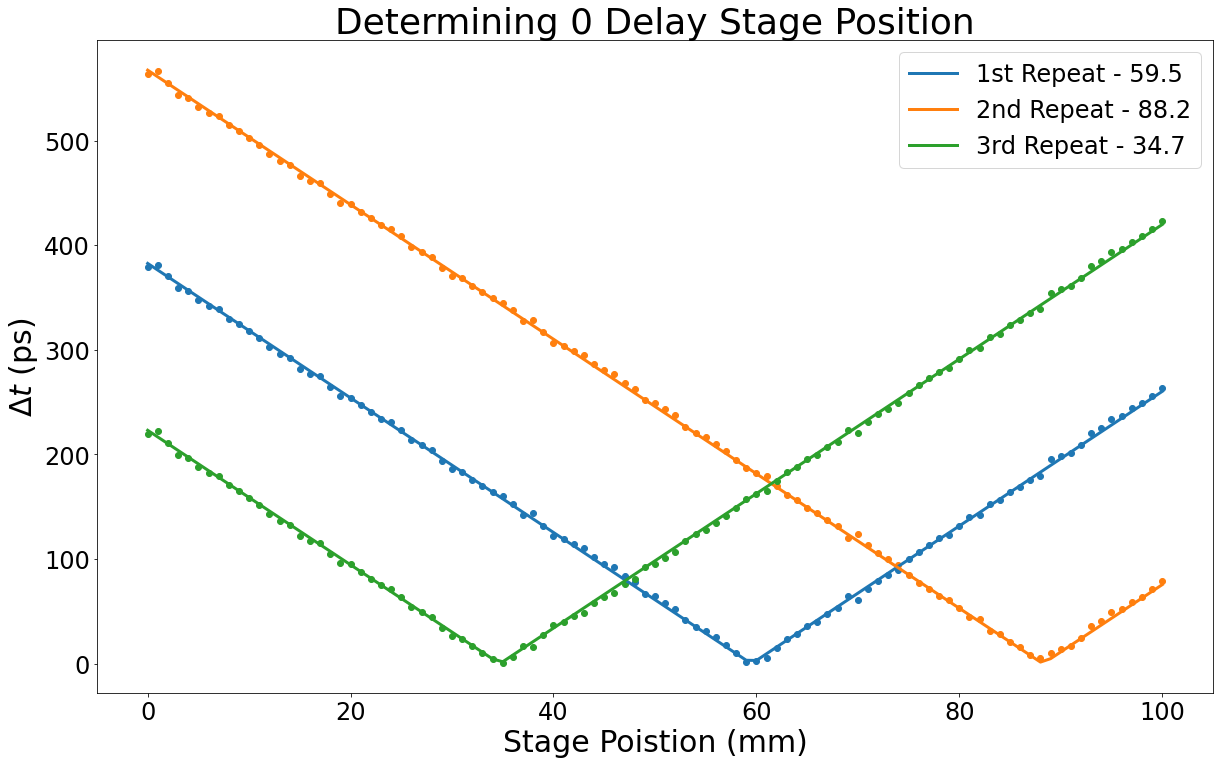

In [118]:
#Plot a graph of the time difference between the green and red pulse as stage position changes
plt.figure(figsize = (20,12))
plt.scatter(np.linspace(0, 100, 101), delta_t1)
plt.plot(np.linspace(0, 100, 101), mod_function(np.linspace(0, 100, 101), delta_t1_params[0], delta_t1_params[1]), label = '1st Repeat - 59.5', linewidth=3)
plt.scatter(np.linspace(0, 100, 101), delta_t2)
plt.plot(np.linspace(0, 100, 101), mod_function(np.linspace(0, 100, 101), delta_t2_params[0], delta_t2_params[1]), label = '2nd Repeat - 88.2', linewidth=3)
plt.scatter(np.linspace(0, 100, 101), delta_t3)
plt.plot(np.linspace(0, 100, 101), mod_function(np.linspace(0, 100, 101), delta_t3_params[0], delta_t3_params[1]), label = '3rd Repeat - 34.7', linewidth=3)
plt.xlabel('Stage Poistion (mm)', fontsize = 30)
plt.ylabel('$\Delta t$ (ps)', fontsize = 30)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.title('Determining 0 Delay Stage Position', fontsize = 36)
plt.legend(fontsize = 24)